# Business Data Science

Abhilash Vikram Gupta

https://www.kaggle.com/c/mis382n-fall-2019

In [185]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

import xgboost as xgb
import lightgbm as lgbm

from IPython.display import display

In [169]:
def get_ind(array): return [index for index, rank in enumerate(array) if rank==True]

df = pd.read_csv('train_final.csv', index_col='Id')
df_ult = pd.read_csv('test_final.csv', index_col='Id')

X = df.drop('Y', axis='columns').values
y = df['Y'].values

n_features = X.shape[1]

X_ult = df_test.values

scale_pos_weight = len(y[y == 0])/len(y[y == 1])

In [170]:
def get_features_backward(clf):
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
    rfecv.fit(X, y)

    return get_ind(rfecv.ranking_ == 1)

In [142]:
def get_features_forward(clf):
    primary = ([], 0)

    for _ in range(n_features):
        best_feature_score = (0, 0)
        remaining_features = np.setdiff1d(list(range(n_features)), primary[0]).tolist()
        for current_feature in remaining_features:
            current_features = primary[0] + [current_feature]
            clf.fit(X[:, current_features], y)
            current_score = roc_auc_score(y, clf.predict_proba(X[:, current_features])[:, 1])
            if current_score > best_feature_score[1]:
                best_feature_score = (current_feature, current_score)
        if best_feature_score[1] > primary[1]:
            primary = (primary[0] + [best_feature_score[0]], best_feature_score[1])
        else:
            break

    print(f'score {primary[1]}.')
    return primary[0]

In [172]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=9)
chi_selector.fit(X_norm, y)

chi_support = chi_selector.get_support()
get_ind(chi_support)

[5, 10, 11, 12, 13, 16, 19, 22, 23]

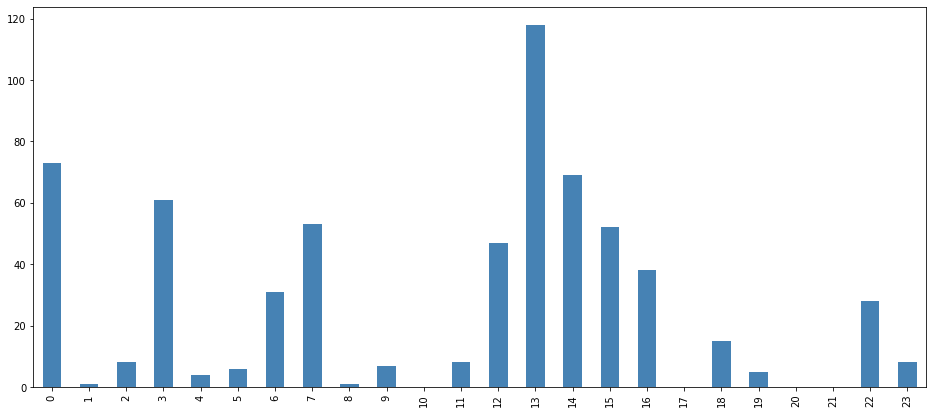

In [179]:
def get_clf():
    return lgbm.LGBMClassifier(learning_rate=0.1, 
                               boosting_type='goss', 
                               max_depth=3, 
                               objective='binary', 
                               scale_pos_weight=scale_pos_weight)

clf = get_clf().fit(X, y)

pd.Series(clf.feature_importances_, index=list(range(n_features))).plot.bar(color='steelblue', figsize=(16, 7));

In [211]:
display(clf.feature_importances_)
get_ind(clf.feature_importances_ >= 47)

array([ 73,   1,   8,  61,   4,   6,  31,  53,   1,   7,   0,   8,  47,
       118,  69,  52,  38,   0,  15,   5,   0,   0,  28,   8], dtype=int32)

[0, 3, 7, 12, 13, 14, 15]

In [182]:
sorted(get_features_forward(get_clf()))

score 0.9268037393780095.


[0, 3, 7, 9, 13, 14, 15, 16, 18]

In [181]:
get_features_backward(get_clf())

[0, 3, 7, 12, 13, 14, 15, 16]

In [214]:
feats_tiny = [0, 3, 7, 13, 14, 15]
feats_small = [0, 3, 7, 12, 13, 14, 15]
feats_med = [0, 3, 7, 12, 13, 14, 15, 16]
feats_big = [0, 3, 6, 7, 12, 13, 14, 15, 16, 22]
feats_all = list(range(X_ult.shape[1]))

clfs = []
for feats in [feats_tiny, feats_small, feats_med, feats_big, feats_all]:
    X_train, X_test, y_train, y_test = train_test_split(X[:, feats], y, test_size=0.1)

    tuned_parameters = [{'n_estimators':                  [340, 360, 380, 400, 420], 
                         'boosting_type':                 ['goss'],
                         'learning_rate':                 [0.1], 
                         'max_depth':                     [5],
                         'num_leaves':                    [33],
                         'objective':                     ['binary'],
                         'scale_pos_weight':              [scale_pos_weight]}]

    grid = GridSearchCV(get_clf(), tuned_parameters, cv=10, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f'Best train accuracy is {grid.best_score_}.')
    print(f'Best parameters {grid.best_params_}.')
    print(f'Best test accuracy is {grid.score(X_test, y_test)}.')
    clfs.append(grid)

Best train accuracy is 0.8669479864292068.
Best parameters {'boosting_type': 'goss', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'num_leaves': 33, 'objective': 'binary', 'scale_pos_weight': 0.06141885325558795}.
Best test accuracy is 0.8262338081003459.
Best train accuracy is 0.8687320514830176.
Best parameters {'boosting_type': 'goss', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'num_leaves': 33, 'objective': 'binary', 'scale_pos_weight': 0.06141885325558795}.
Best test accuracy is 0.8851706036745407.
Best train accuracy is 0.8691875327281109.
Best parameters {'boosting_type': 'goss', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 420, 'num_leaves': 33, 'objective': 'binary', 'scale_pos_weight': 0.06141885325558795}.
Best test accuracy is 0.8946639958825411.
Best train accuracy is 0.865179622257405.
Best parameters {'boosting_type': 'goss', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 420, 'num_leaves': 33, 'objective': 'binary', 'scale_po

In [235]:
preds_dfs = [pd.DataFrame(clf.predict_proba(X_ult[:, feats])[:, 1], 
                          index=list(range(16384, 32768 + 1)), 
                          columns=['Y']) for feats, clf in 
         zip([feat_tiny, feat_small, feat_med, feat_big, feat_all], clfs)]

for idx, df in enumerate(preds_dfs):
    df.index.name = 'Id'
    df.to_csv(f'submission_22_{idx}.csv')